# Importación de librerías

In [1]:
import warnings
warnings.filterwarnings('ignore') 

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os
import re # Expresiones regulares
from sklearn import preprocessing # LabelEncoder
import pickle #Guardado binario

In [3]:
data = pd.read_table("../Dataset/labeledEligibilitySample10k.csv", header = None)

In [4]:
print(data.shape)

(10000, 1)


### Se transforma la variable elegible (la salida) en 0 y 1

In [5]:
clin_trial = pd.DataFrame(np.array(data).reshape(10000,1), columns=['Description'])
#clin_trial[:].head(10)

In [6]:
clin_trial['Num'], clin_trial['ExtraPart'] = clin_trial['Description'].str.split(',', 1).str
clin_trial=clin_trial.drop(['Num'], axis=1)

clin_trial['Label'], clin_trial['TrashPart'] = clin_trial['ExtraPart'].str.split(',', 1).str
clin_trial['Eligible'] = clin_trial['Label'].str.extract('(\d)', expand=True)
clin_trial=clin_trial.drop(['Label'], axis=1)
clin_trial=clin_trial.drop(['ExtraPart'], axis=1)

clin_trial['Interventions'], clin_trial['Diagnoses'] = clin_trial['TrashPart'].str.split('.', 1).str
clin_trial=clin_trial.drop(['TrashPart'], axis=1)

clin_trial=clin_trial.drop(['Description'], axis=1)

#clin_trial.head(10)

In [7]:
# Se quita study interventions are puesto que está en todas las muestras de la varialbe Interventions
clin_trial['Interventions'] = clin_trial['Interventions'].str.replace("study interventions are\s", "")
clin_trial.sample(10)

,Eligible,Interventions,Diagnoses
4268,0,Antibodies,recurrent squamous cell carcinoma of the para...
9122,1,"""Antibodies, Monoclonal",fallopian tube cancer diagnosis and unstable ...
2074,0,"""Antibodies, Monoclonal",prostate cancer diagnosis and platelets great...
3564,0,Vidarabine,small intestine lymphoma diagnosis and hemato...
301,0,Varenicline,breast cancer diagnosis and advised to quit s...
8531,1,Gemcitabine,non small cell lung cancer diagnosis and prev...
7710,1,Temozolomide,ependymoma diagnosis and known hiv positivity;
870,0,Dexamethasone 21-phosphate,pancreatic cancer diagnosis and use of effect...
2973,0,Immunoglobulins,neoplasms diagnosis and world health organisa...
4117,0,ABT-751,unspecified childhood solid tumor protocol sp...


In [8]:
# Se transforma todo a minúsculas
clin_trial['Interventions'] = clin_trial['Interventions'].str.lower() ##Todo a minúscula
clin_trial['Diagnoses'] = clin_trial['Diagnoses'].str.lower()     ##Todo a minúscula

#Se reemplazan vocales con tildes en ambas variables
clin_trial['Interventions'] = clin_trial['Interventions'].str.replace('[áäâà]', 'a', regex=True)
clin_trial['Interventions'] = clin_trial['Interventions'].str.replace('[éêèë]', 'e', regex=True)
clin_trial['Interventions'] = clin_trial['Interventions'].str.replace('[íïìî]', 'i', regex=True)
clin_trial['Interventions'] = clin_trial['Interventions'].str.replace('[óôòö]', 'o', regex=True)
clin_trial['Interventions'] = clin_trial['Interventions'].str.replace('[úûùü]', 'u', regex=True)
clin_trial['Interventions'] = clin_trial['Interventions'].str.replace('["]', '', regex=True)

clin_trial['Diagnoses'] = clin_trial['Diagnoses'].str.replace('[áäâà]', 'a', regex=True)
clin_trial['Diagnoses'] = clin_trial['Diagnoses'].str.replace('[éêèë]', 'e', regex=True)
clin_trial['Diagnoses'] = clin_trial['Diagnoses'].str.replace('[íïìî]', 'i', regex=True)
clin_trial['Diagnoses'] = clin_trial['Diagnoses'].str.replace('[óôòö]', 'o', regex=True)
clin_trial['Diagnoses'] = clin_trial['Diagnoses'].str.replace('[úûùü]', 'u', regex=True)
clin_trial['Diagnoses'] = clin_trial['Diagnoses'].str.replace('^\s', '', regex=True)
clin_trial['Diagnoses'] = clin_trial['Diagnoses'].str.replace('["]', '', regex=True)
clin_trial['Diagnoses'] = clin_trial['Diagnoses'].str.replace('[;]', '', regex=True)

#clin_trial.sample(10)

In [9]:
# Total de categorías diferentes en la variable Interventions
len(np.unique(clin_trial['Interventions'])) 

1426

In [10]:
# Total de categorías diferentes en la variable Diagnoses
len(np.unique(clin_trial['Diagnoses']))

9786

## Codificación de la variable Interventions

In [11]:
labels = np.unique(clin_trial['Interventions'])

lb_interventions = preprocessing.LabelEncoder()
lb_interventions.fit(labels)
clin_trial['Interventions'] = lb_interventions.transform(clin_trial['Interventions']) 

# Remover Stop Words

## Preliminares

In [12]:
# Se carga la libreria
from nltk.corpus import stopwords

# Se debe descargar el conjunto de 'Stop Words' la primera vez
import nltk
nltk.download('stopwords')

#Se carga la librería de lematización
#PONER conda install -c conda-forge spacy EN ANACONDA PROMPT
# Y python -m spacy download en_core_web_sm

#Se carga la librería de lematización
import spacy
nlp = spacy.load("en_core_web_sm")

#Se carga la librería de stemming y se inicializa el stemmer
import nltk
from nltk import SnowballStemmer
stemmer=SnowballStemmer('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\danie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Crear las palabras Token

## Lematización

"Dada una forma flexionada (es decir, en plural, en femenino, conjugada, etc), hallar el lema correspondiente. El lema es la forma que por convenio se acepta como representante de todas las formas flexionadas de una misma palabra. Es decir, el lema de una palabra es la palabra que nos encontraríamos como entrada en un diccionario tradicional: singular para sustantivos, masculino singular para adjetivos, infinitivo para verbos." -Wikipedia

In [13]:
#https://medium.com/qu4nt/reducir-el-número-de-palabras-de-un-texto-lematización-y-radicalización-stemming-con-python-965bfd0c69fa
toks = []

for sample in clin_trial['Diagnoses']:
    words = nlp(sample)
    lemma = [tok.lemma_.lower() for tok in words]
    #print(lemma)
    toks.append(lemma)
    

## Cargar las Stop Words

In [14]:
# Carga las Stop Words en inglés
stop_words = stopwords.words('english')

## Estaría bien revisar este conjunto 'english'. Pero supongo que es el más útil para nuestro caso también.
# Imprime algunas Stop Words
#stop_words[:100]

## Remover las Stop Words

In [15]:
tokens = []
for tok in toks:
    clean_word = [word for word in tok if word not in stop_words]
    tokens.append(clean_word)

## Stemming

"Es un método para reducir una palabra a su raíz o (en inglés) a un stem." - Wikipedia

In [16]:
stemms = []
for tok in tokens:
    var = [stemmer.stem(token) for token in tok]
    stemms.append(var)

In [17]:
#Guardar las stemms

fichero_stemms = open("archivo_stemms", "wb")
pickle.dump(stemms, fichero_stemms)

fichero_stemms.close()
del fichero_stemms

# TF-IDF 
Term frequency – Inverse document frequency

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [19]:
#Cargar los stemms

fichero = open("archivo_stemms", "rb")
stemms = pickle.load(fichero)

fichero.close()

In [20]:
stemmsT = [ ' '.join(stemms[item]) for item in range (len(stemms))] #Se transforma de lista de listas a una lista

In [21]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(stemmsT)

In [22]:
cols = vectorizer.get_feature_names()
dense = X.todense()
denselist = dense.tolist()

In [23]:
df = pd.DataFrame(data=denselist, columns= cols)

In [24]:
del clin_trial['Diagnoses']
df = pd.concat([clin_trial, df], axis=1)

In [25]:
df.to_hdf('df_prueba.h5', key = 'clin_trial')

# Ordenar y eliminar palabras

In [26]:
df = pd.read_hdf('df_prueba.h5', 'clin_trial')

In [27]:
eligible = df['Eligible'].values #Para ver las palabras por clase

dict_0 = {}
dict_1 = {}

for col in df:
    if(col == 'Eligible' or col == 'Interventions'):
        continue
    ar = df[col].values
    condlist = [(eligible == "1") & (ar != 0.0), (eligible == "0") & (ar != 0.0)]
    choicelist = [1, 2]
    res = np.select(condlist, choicelist)
    
    dict_0[col] = len(res[res==2])
    dict_1[col] = len(res[res==1])
    
#     print(col + " tiene ", len(res[res==2]), " apariciones en la clase 0")
#     print(col + " tiene ", len(res[res==1]), " apariciones en la clase 1 \n")

In [28]:
final_words = []
for a,b in zip (dict_0, dict_1): #Para imprimir las palabras
    if((dict_0[a]/(dict_0[a]+dict_1[b])<=0.35 or dict_0[a]/(dict_0[a]+dict_1[b])>=0.65) and (dict_0[a]+dict_1[b])>=12):
#         anterior con 0.37, 0.63, 11
#         print(dict_0[a]/(dict_0[a]+dict_1[b]))
#print(a + " tiene ", dict_0[a], " muestras en la clase 0 \n" + b + " tiene ", dict_1[b], " muestras en la clase 1")
        final_words.append(a)

In [29]:
len(final_words)

657

In [30]:
final_words.insert(0,'Eligible')
final_words.insert(1,'Interventions')

In [31]:
aux = df
for word in df:
    if word not in final_words:
        del aux[word]

In [32]:
print(aux.shape)
df = aux

(10000, 659)


In [33]:
print(len(dict_0), len(final_words))

5264 659


In [34]:
df

,Eligible,Interventions,abdomin,abl,abscess,absolut,absorpt,abstin,accord,accur,...,withdraw,within,woman,wort,would,wound,write,york,zero,zubrod
0,0,464,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
1,0,101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
2,0,349,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
3,0,1052,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.099676,0.0
4,0,708,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1,1109,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
9996,1,200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
9997,1,1201,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.210823,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
9998,1,939,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.366276,0.0,0.0,0.000000,0.0


# Guardado del modelo

In [35]:
df.to_hdf('prueba.h5', key = 'clin_trial')

In [3]:
df = pd.read_hdf('prueba.h5', 'clin_trial')

In [4]:
df

,Eligible,Interventions,abdomin,abl,abscess,absolut,absorpt,abstin,accord,accur,...,withdraw,within,woman,wort,would,wound,write,york,zero,zubrod
0,0,464,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
1,0,101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
2,0,349,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
3,0,1052,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.099676,0.0
4,0,708,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1,1109,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
9996,1,200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
9997,1,1201,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.210823,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
9998,1,939,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.366276,0.0,0.0,0.000000,0.0


# Classification

In [4]:
from sklearn.preprocessing import MinMaxScaler # Escala los datos
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
import scikitplot as skplt 
from string import ascii_uppercase 
# import seaborn as sns
import qgrid
import time
#from sklearn.externals import joblib # Para guardar el modelo
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

#from mlxtend.feature_selection import SequentialFeatureSelector as SFS
#from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

from scipy import stats #Para la moda

In [5]:
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LogisticRegression

In [6]:
clin_trial_values = df.values
Y = clin_trial_values[:, 0]
Y = Y.astype(int)
X = clin_trial_values[:, 1:]

In [7]:
def classification_error(y_est, y_real):
    err = 0
    for y_e, y_r in zip(y_est, y_real):

        if y_e != y_r:
            err += 1

    return err/np.size(y_est)

In [8]:
def plot_roc(Xtest, Ytest, probs, xlabel):
    ns_probs = [0 for _ in range(len(Ytest))]
    
    probs = probs[:, 1]
    ns_auc = roc_auc_score(Ytest, ns_probs)
    auc = roc_auc_score(Ytest, probs)  

    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print(xlabel, 'ROC AUC=%.3f' % (auc))

    ns_fpr, ns_tpr, _ = roc_curve(Ytest, ns_probs)
    fpr, tpr, _ = roc_curve(Ytest, probs)   

    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(fpr, tpr, marker='.', label= xlabel)

    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

# KNN

In [10]:
from sklearn.neighbors import KNeighborsClassifier

In [51]:
np.array((10,1))

array([10,  1])

In [14]:
def model_KNN(k, impresion = False):

    tiempo_i = time.time()

    accuracy_list = np.zeros([4])
    accuracy_list_train = np.zeros([4])
    precision_list = np.zeros([4,2])
    recall_list = np.zeros([4,2])
    f_list = np.zeros([4,2]) 
    errores = np.zeros(4)
    knn = KNeighborsClassifier(k)
    list_acc_mean = []
    list_acc_train_mean = []
    list_acc_std = []
    list_acc_train_std = []
    list_percentage = [0.05,0.10,0.15,0.20,0.25,0.3]
    
    for i in list_percentage:
        for j in range(4):
            Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=i) # Modificar metodología de validación
            scaler = MinMaxScaler()#Escala entre 0 y 1
            Xtrain = scaler.fit_transform(Xtrain)
            Xtest = scaler.transform(Xtest)

            knn.fit(Xtrain, Ytrain)
            pred = knn.predict(Xtest)
            pred_train = knn.predict(Xtrain)

            #code for calculating accuracy 
            _accuracy_ = accuracy_score(Ytest, pred, normalize=True)
            accuracy_list[j] = _accuracy_

            _accuracy_train_ = accuracy_score(Ytrain, pred_train, normalize=True)
            accuracy_list_train[j] = _accuracy_train_            
            
            #code for calculating recall 
            _recalls_ = recall_score(Ytest, pred, average=None)
            recall_list[j] = _recalls_

            #code for calculating precision 
            _precisions_ = precision_score(Ytest, pred, average=None)
            precision_list[j] = _precisions_

            _f_score_ = f1_score(Ytest, pred, average=None)
            f_list[j] = _f_score_

            errores[j] = classification_error(pred, Ytest)
            
            print(i, j)
            
        list_acc_mean.append(np.mean(accuracy_list))
        list_acc_std.append(np.std(accuracy_list))
        list_acc_train_mean.append(np.mean(accuracy_list_train))
        list_acc_train_std.append(np.std(accuracy_list_train))
          
    if impresion == True:
        
        x = [10000-(i* 10000) for i in list_percentage]
        sneg = [m-s for m,s in zip(list_acc_mean,list_acc_std)]
        spos = [m+s for m,s in zip(list_acc_mean,list_acc_std)]
        
        sneg_train = [m-s for m,s in zip(list_acc_train_mean,list_acc_train_std)]
        spos_train = [m+s for m,s in zip(list_acc_train_mean,list_acc_train_std)]
        
        fig1, ax1 = plt.subplots()
        
        ax1.fill_between(x,sneg_train,spos_train,alpha=.1)
        ax1.plot(x, list_acc_train_mean, marker = 'v', label = "train")
        ax1.fill_between(x,sneg,spos,alpha=.1)
        ax1.plot(x, list_acc_mean, marker = 'p', label = "test")

        ax1.set_xlabel("Número de muestras para train")
        ax1.set_ylabel("Accuracy")

        ax1.legend(loc="upper right", title="Curva de aprendizaje", frameon=False)
        plt.show()
        
        #Curva ROC
        
        knn_probs = knn.predict_proba(Xtest)
        
        plot_roc(Xtest, Ytest, knn_probs, "KNN")

        skplt.metrics.plot_confusion_matrix(Ytest, pred, normalize=True)

    return str(np.mean(accuracy_list)), str(np.std(accuracy_list)), str(np.mean(recall_list)), str(np.std(recall_list)), str(np.mean(precision_list)), str(np.std(precision_list)),  str(np.mean(f_list)), str(np.std(f_list)), str(np.mean(errores)), str(np.std(errores)), str(time.time()-tiempo_i)

0.05 0
0.05 1
0.05 2
0.05 3
0.1 0
0.1 1
0.1 2
0.1 3
0.15 0
0.15 1
0.15 2
0.15 3
0.2 0
0.2 1
0.2 2
0.2 3
0.25 0
0.25 1
0.25 2
0.25 3
0.3 0
0.3 1
0.3 2
0.3 3


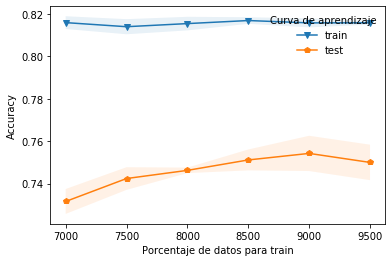

No Skill: ROC AUC=0.500
KNN ROC AUC=0.811


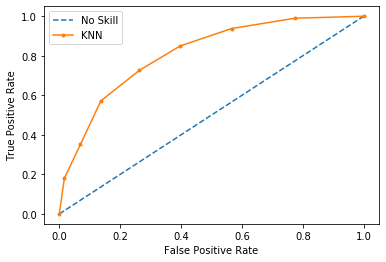

Eficiencia 0.7315833333333333  Int_Eficiencia 0.005870713566320359  Sensibilidad 0.7316547275211547  Int_Sensibilidad 0.024987157881375455  Precision 0.7321512501313983  Int_Precision 0.013673944237228565  F-Score 0.7314436462158056  Int_F-Score 0.008645910638403307  Error_Prueba 0.26841666666666664  Int_Error 0.005870713566320359  Tiempo ejecución 2884.689051389694


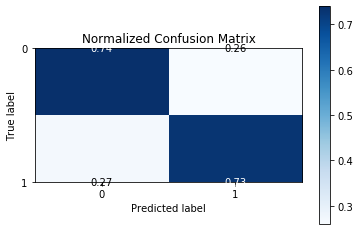

In [15]:
Acc, IntAcc, Sen, IntSen, Pre, IntPre, f, IntF, error, stdError, tiempo = model_KNN(7, impresion = True)
print('Eficiencia',Acc, ' Int_Eficiencia', IntAcc,' Sensibilidad', Sen, ' Int_Sensibilidad',IntSen,' Precision', Pre, ' Int_Precision',IntPre,' F-Score', f, ' Int_F-Score',IntF,' Error_Prueba', error,' Int_Error', stdError,' Tiempo ejecución', tiempo)

In [47]:
pd.options.mode.chained_assignment = None

randn = np.random.randn
df_types = pd.DataFrame({
    'Numero de vecinos' : pd.Series(['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20'])})
df_types["Eficiencia"] = ""
df_types["Int_Eficiencia"] = ""
df_types["Sensibilidad"] = ""
df_types["Int_Sensibilidad"] = ""
df_types["Precision"] = ""
df_types["Int_Precision"] = ""
df_types["F-Score"] = ""
df_types["Int_F-Score"] = ""
df_types["Error_Prueba"] = ""
df_types["Int_error"] = ""
df_types["Tiempo de ejecución"] = ""
df_types.set_index(['Numero de vecinos'], inplace=True)

i = 0
for k in df_types.index:
    Acc, IntAcc, Sen, IntSen, Pre, IntPre, f, IntF, error, stdError, tiempo = model_KNN(int(k), impresion = False)
    df_types["Eficiencia"][i] = Acc
    df_types["Int_Eficiencia"][i] = IntAcc
    df_types["Sensibilidad"][i] = Sen
    df_types["Int_Sensibilidad"][i] = IntSen
    df_types["Precision"][i] = Pre
    df_types["Int_Precision"][i] = IntPre
    df_types["F-Score"][i] = f
    df_types["Int_F-Score"][i] = IntF
    df_types["Error_Prueba"][i] = error
    df_types["Int_error"][i] = stdError
    df_types["Tiempo de ejecución"][i] = tiempo
    
    i += 1
    
qgrid_widget = qgrid.show_grid(df_types, show_toolbar=False)
qgrid_widget

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [48]:
qgrid_widget.get_changed_df()

,Eficiencia,Int_Eficiencia,Sensibilidad,Int_Sensibilidad,Precision,Int_Precision,F-Score,Int_F-Score,Error_Prueba,Int_error,Tiempo de ejecución
Numero de vecinos,,,,,,,,,,,
1,0.7297,0.008420807562223494,0.7296075037288952,0.013482240240093668,0.7297072952618782,0.009523824263356897,0.7296066770487959,0.009964202840790297,0.2703,0.008420807562223463,31.71083903312683
2,0.713,0.004294182110716777,0.7117717381776518,0.16284734333573767,0.7373799670928738,0.07451835193573501,0.7046292940916106,0.04997088533007255,0.287,0.004294182110716784,38.815572023391724
3,0.7385,0.009407975340103748,0.7393397296653892,0.029567934881172316,0.7395329862914867,0.026832883479508154,0.738478016311356,0.009700727852253574,0.2615,0.009407975340103732,42.546706676483154
4,0.7288,0.013127071265137564,0.7284269056871098,0.10357981109686759,0.7385167365732637,0.04893733937833551,0.7256739862831718,0.0326456855500337,0.2712,0.013127071265137546,45.03692865371704
5,0.7379,0.006371028174478602,0.7381385236438026,0.0316190353991999,0.7388795458972199,0.019993929142642978,0.7376836857556562,0.009862815002036942,0.2621,0.006371028174478588,46.100895404815674
6,0.7332,0.0057480431452799526,0.7336920715699311,0.09276128224959687,0.7417116210194794,0.047701287267161274,0.7310544027967334,0.024736246950412533,0.2668,0.0057480431452799725,46.73747277259827
7,0.7492,0.010015987220439091,0.749075212554417,0.028111240523265236,0.7497514490648397,0.015762974936898495,0.7489434766924346,0.013145370175410103,0.2508,0.01001598722043913,47.955580711364746
8,0.7362,0.006069596362197411,0.7359323876167569,0.07601661999969966,0.7415057002331602,0.03695136825876887,0.7344717104742674,0.022116092569194654,0.2638,0.006069596362197422,48.49106740951538
9,0.7478,0.006403124237432864,0.7479415832104749,0.023750063510655433,0.7483513637001834,0.01628254486774528,0.7476913117730095,0.008284601646618567,0.25220000000000004,0.0064031242374328525,49.21972990036011


# Naive Bayes

In [12]:
from sklearn.naive_bayes import GaussianNB

In [19]:
def model_NB(impresion = False):

    tiempo_i = time.time()
    accuracy_list_train = np.zeros([10])
    accuracy_list = np.zeros([10])
    precision_list = np.zeros([10,2])
    recall_list = np.zeros([10,2])
    f_list = np.zeros([10,2]) 
    errores = np.zeros(10)
    nb = GaussianNB()
    list_acc_mean = []
    list_acc_train_mean = []
    list_acc_std = []
    list_acc_train_std = []
    list_percentage = [0.05,0.10,0.15,0.20,0.25,0.3]
    
    for i in list_percentage:
        for j in range(10):
            Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=i) # Modificar metodología de validación
            scaler = MinMaxScaler()#Escala entre 0 y 1
            Xtrain = scaler.fit_transform(Xtrain)
            Xtest = scaler.transform(Xtest)

            nb.fit(Xtrain, Ytrain)
            pred = nb.predict(Xtest)
            pred_train = nb.predict(Xtrain)

            #code for calculating accuracy 
            _accuracy_ = accuracy_score(Ytest, pred, normalize=True)
            accuracy_list[j] = _accuracy_
        
            _accuracy_train_ = accuracy_score(Ytrain, pred_train, normalize=True)
            accuracy_list_train[j] = _accuracy_train_     

            #code for calculating recall 
            _recalls_ = recall_score(Ytest, pred, average=None)
            recall_list[j] = _recalls_

            #code for calculating precision 
            _precisions_ = precision_score(Ytest, pred, average=None)
            precision_list[j] = _precisions_

            _f_score_ = f1_score(Ytest, pred, average=None)
            f_list[j] = _f_score_

            errores[j] = classification_error(pred, Ytest)
            print(i, j)
            
        list_acc_mean.append(np.mean(accuracy_list))
        list_acc_std.append(np.std(accuracy_list))
        list_acc_train_mean.append(np.mean(accuracy_list_train))
        list_acc_train_std.append(np.std(accuracy_list_train))
          
    if impresion == True:
        
        x = [10000-(i* 10000) for i in list_percentage]
        sneg = [m-s for m,s in zip(list_acc_mean,list_acc_std)]
        spos = [m+s for m,s in zip(list_acc_mean,list_acc_std)]
        
        sneg_train = [m-s for m,s in zip(list_acc_train_mean,list_acc_train_std)]
        spos_train = [m+s for m,s in zip(list_acc_train_mean,list_acc_train_std)]
        
        fig1, ax1 = plt.subplots()
        
        ax1.fill_between(x,sneg_train,spos_train,alpha=.1)
        ax1.plot(x, list_acc_train_mean, marker = 'v', label = "train")
        ax1.fill_between(x,sneg,spos,alpha=.1)
        ax1.plot(x, list_acc_mean, marker = 'p', label = "test")

        ax1.set_xlabel("Número de muestras para train")
        ax1.set_ylabel("Accuracy")

        ax1.legend(loc="upper right", title="Curva de aprendizaje", frameon=False)
        plt.show()
            
        #Curva ROC
        nb_probs = nb.predict_proba(Xtest)
        
        plot_roc(Xtest, Ytest, nb_probs, "Naive Bayes")
        skplt.metrics.plot_confusion_matrix(Ytest, pred, normalize=True)

    return str(np.mean(accuracy_list)), str(np.std(accuracy_list)), str(np.mean(recall_list)), str(np.std(recall_list)), str(np.mean(precision_list)), str(np.std(precision_list)),  str(np.mean(f_list)), str(np.std(f_list)), str(np.mean(errores)), str(np.std(errores)), str(time.time()-tiempo_i)

0.05 0
0.05 1
0.05 2
0.05 3
0.05 4
0.05 5
0.05 6
0.05 7
0.05 8
0.05 9
0.1 0
0.1 1
0.1 2
0.1 3
0.1 4
0.1 5
0.1 6
0.1 7
0.1 8
0.1 9
0.15 0
0.15 1
0.15 2
0.15 3
0.15 4
0.15 5
0.15 6
0.15 7
0.15 8
0.15 9
0.2 0
0.2 1
0.2 2
0.2 3
0.2 4
0.2 5
0.2 6
0.2 7
0.2 8
0.2 9
0.25 0
0.25 1
0.25 2
0.25 3
0.25 4
0.25 5
0.25 6
0.25 7
0.25 8
0.25 9
0.3 0
0.3 1
0.3 2
0.3 3
0.3 4
0.3 5
0.3 6
0.3 7
0.3 8
0.3 9


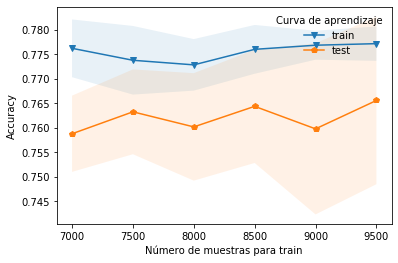

No Skill: ROC AUC=0.500
Naive Bayes ROC AUC=0.815


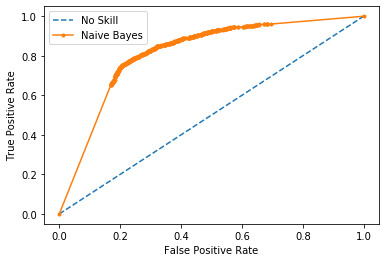

Accuracy 0.7588  Int_Accuracy 0.0077877396520998855  Sensibility 0.7589224392798857  Int_Sensibility 0.054436811200743444  Precision 0.7618448435656865  Int_Precision 0.029550607982960907  F-Score 0.7581159717151674  Int_F-Score 0.015391235675421774  Error 0.2412  Int_Error 0.00778773965209989  Execution time 65.93050599098206


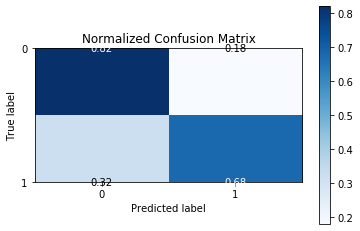

In [20]:
Acc, IntAcc, Sen, IntSen, Pre, IntPre, f, IntF, error, stdError, tiempo = model_NB(impresion = True)
print('Accuracy',Acc, ' Int_Accuracy', IntAcc,' Sensibility', Sen, ' Int_Sensibility',IntSen,' Precision', Pre, ' Int_Precision',IntPre,' F-Score', f, ' Int_F-Score',IntF,' Error', error,' Int_Error', stdError,' Execution time', tiempo)

# Logistic Regression

In [52]:
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LogisticRegression

In [53]:
def LRC(c, slv, impresion = False):

    tiempo_i = time.time()
    
    accuracy_list = np.zeros([4])
    precision_list = np.zeros([4,2])
    recall_list = np.zeros([4,2])
    f_list = np.zeros([4,2]) 
    errores = np.zeros(4)
    LR = LogisticRegression(C=c, solver=slv, max_iter = 200)
    for j in range(4):
        Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.25) # Modificar metodología de validación
        scaler = MinMaxScaler()#Escala entre 0 y 1
        Xtrain = scaler.fit_transform(Xtrain)
        Xtest = scaler.transform(Xtest)
        
        LR.fit(Xtrain, Ytrain)
        pred = LR.predict(Xtest)
        
        #code for calculating accuracy 
        _accuracy_ = accuracy_score(Ytest, pred, normalize=True)
        accuracy_list[j] = _accuracy_

        #code for calculating recall 
        _recalls_ = recall_score(Ytest, pred, average=None)
        recall_list[j] = _recalls_

        #code for calculating precision 
        _precisions_ = precision_score(Ytest, pred, average=None)
        precision_list[j] = _precisions_
        
        _f_score_ = f1_score(Ytest, pred, average=None)
        f_list[j] = _f_score_

                
        errores[j] = classification_error(pred, Ytest)
           
    if impresion == True:
        #Curva ROC
        
        lr_probs = LR.predict_proba(Xtest)
        
        plot_roc(Xtest, Ytest, lr_probs, "Logistic Regression")
        
#         auc = roc_auc_score(Ytest, pred)
#         print('AUC: %.2f' % auc)
#         fpr, tpr, thresholds = roc_curve(Ytest, pred)
#         plot_roc_curve(fpr, tpr)
        #Matriz de confusión
        skplt.metrics.plot_confusion_matrix(Ytest, pred, normalize=True)

    return str(np.mean(accuracy_list)), str(np.std(accuracy_list)), str(np.mean(recall_list)), str(np.std(recall_list)), str(np.mean(precision_list)), str(np.std(precision_list)),  str(np.mean(f_list)), str(np.std(f_list)), str(np.mean(errores)), str(np.std(errores)), str(time.time()-tiempo_i)

No Skill: ROC AUC=0.500
Logistic Regression ROC AUC=0.867


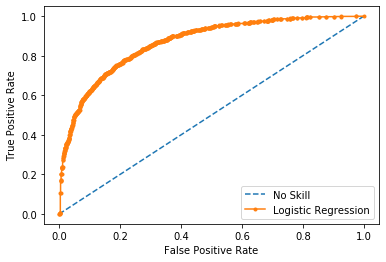

Eficiencia 0.773  Int_Eficiencia 0.0051961524227066595  Sensibilidad 0.7734410699781873  Int_Sensibilidad 0.02460555405800438  Precision 0.7736800047053509  Int_Precision 0.02108325825726094  F-Score 0.7729415726285025  Int_F-Score 0.006383504882956779  Error_Prueba 0.227  Int_Error 0.005196152422706631  Tiempo ejecución 1.9807991981506348


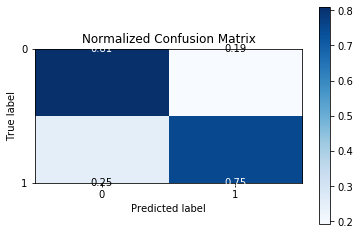

In [54]:
Acc, IntAcc, Sen, IntSen, Pre, IntPre, f, IntF, error, stdError, tiempo = LRC(1, 'liblinear', impresion = True)
print('Eficiencia',Acc, ' Int_Eficiencia', IntAcc,' Sensibilidad', Sen, ' Int_Sensibilidad',IntSen,' Precision', Pre, ' Int_Precision',IntPre,' F-Score', f, ' Int_F-Score',IntF,' Error_Prueba', error,' Int_Error', stdError,' Tiempo ejecución', tiempo)

In [55]:
pd.options.mode.chained_assignment = None

#randn = np.random.randn
df_types = pd.DataFrame({
    'Tipo de solver' : pd.Series(['newton-cg', 'newton-cg', 'newton-cg', 'newton-cg', 'newton-cg', 'newton-cg', 
                          'lbfgs', 'lbfgs', 'lbfgs', 'lbfgs', 'lbfgs', 'lbfgs', 
                          'liblinear', 'liblinear', 'liblinear','liblinear','liblinear','liblinear',
                          'sag','sag','sag','sag','sag','sag',
                          'saga','saga','saga','saga','saga','saga']),
    'Valor de regularización' : pd.Series([0.1,0.5,1,1.5,2,3,
                                           0.1,0.5,1,1.5,2,3,
                                           0.1,0.5,1,1.5,2,3,
                                           0.1,0.5,1,1.5,2,3,
                                           0.1,0.5,1,1.5,2,3])})
df_types["Eficiencia"] = ""
df_types["Int_Eficiencia"] = ""
df_types["Sensibilidad"] = ""
df_types["Int_Sensibilidad"] = ""
df_types["Precision"] = ""
df_types["Int_Precision"] = ""
df_types["F-Score"] = ""
df_types["Int_F-Score"] = ""
df_types["Error_Prueba"] = ""
df_types["Int_error"] = ""
df_types["Tiempo de ejecución"] = ""
df_types.set_index(['Tipo de solver', 'Valor de regularización'], inplace=True)

i = 0
for k, n in df_types.index:
    Acc, IntAcc, Sen, IntSen, Pre, IntPre, f, IntF, error, stdError, tiempo = LRC(n, k, impresion = False)
    df_types["Eficiencia"][i] = Acc
    df_types["Int_Eficiencia"][i] = IntAcc
    df_types["Sensibilidad"][i] = Sen
    df_types["Int_Sensibilidad"][i] = IntSen
    df_types["Precision"][i] = Pre
    df_types["Int_Precision"][i] = IntPre
    df_types["F-Score"][i] = f
    df_types["Int_F-Score"][i] = IntF
    df_types["Error_Prueba"][i] = error
    df_types["Int_error"][i] = stdError
    df_types["Tiempo de ejecución"][i] = tiempo
    
    i += 1
    
qgrid_widget = qgrid.show_grid(df_types, show_toolbar=False)
qgrid_widget

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [56]:
qgrid_widget.get_changed_df()

Eficiencia  \
Tipo de solver Valor de regularización                       
newton-cg      0.1                      0.7782999999999999   
               0.5                      0.7897000000000001   
               1.0                      0.7774999999999999   
               1.5                                  0.7804   
               2.0                                  0.7793   
               3.0                                  0.7755   
lbfgs          0.1                                  0.7702   
               0.5                                  0.7853   
               1.0                      0.7822000000000001   
               1.5                                  0.7786   
               2.0                      0.7809999999999999   
               3.0                                  0.7735   
liblinear      0.1                                  0.7728   
               0.5                      0.7845000000000001   
               1.0                                   0.787   
               1.5                                  0.7776   
               2.0                                  0.7801   
               3.0                                  0.7723   
sag            0.1                      0.7705000000000001   
               0.5                                  0.7812   
               1.0                                  0.7795   
               1.5                                  0.7812   
               2.0                      0.7857000000000001   
               3.0                      0.7733000000000001   
saga           0.1                                  0.7701   
               0.5                                  0.7769   
               1.0                                  0.7902   
               1.5                                  0.7759   
               2.0                      0.7790999999999999   
               3.0                                  0.7798   

                                                Int_Eficiencia  \
Tipo de solver Valor de regularización                           
newton-cg      0.1                        0.003681032463861179   
               0.5                        0.007202083032012346   
               1.0                        0.005376802023508037   
               1.5                        0.007984985911070863   
               2.0                         0.00965142476528728   
               3.0                        0.005435991169970754   
lbfgs          0.1                        0.010516653460107923   
               0.5                       0.0035818989377144283   
               1.0                       0.0030265491900843193   
               1.5                        0.006660330322138727   
               2.0                        0.005015974481593786   
               3.0                        0.007628237017817411   
liblinear      0.1                        0.003599999999999983   
               0.5                        0.006062177826491056   
               1.0                        0.004512205669071405   
               1.5                       0.0068468971074494974   
               2.0                         0.00228691932520585   
               3.0                       0.0036152454965050485   
sag            0.1                       0.0027766886753829625   
               0.5                        0.004009987531152686   
               1.0                       0.0033030289129827397   
               1.5                      0.00028284271247458785   
               2.0                        0.009416474924301579   
               3.0                        0.004910193478876377   
saga           0.1                       0.0016340134638368209   
               0.5                        0.003702701716314748   
               1.0                       0.0070228199464317746   
               1.5                        0.008810788840960817   
               2.0                        0.006237788069500272   
               3.

# Random Forest

In [10]:
from sklearn.ensemble import RandomForestClassifier # Se llama a la librería del método Random Forest

In [11]:
def model_RF(estimadores, caracteristicas, impresion = False):
        
    tiempo_i = time.time()
    
    accuracy_list = np.zeros([4])
    precision_list = np.zeros([4,2])
    recall_list = np.zeros([4,2])
    f_list = np.zeros([4,2]) 
    errores = np.zeros(4)
    
    RF = RandomForestClassifier(n_estimators=estimadores, max_features =caracteristicas, n_jobs = -1)
    
    for j in range(4):
        Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.25)
        scaler = MinMaxScaler()#Escala entre 0 y 1
        Xtrain = scaler.fit_transform(Xtrain)
        Xtest = scaler.transform(Xtest)
        
        RF.fit(Xtrain, Ytrain)
        pred = RF.predict(Xtest)
        
        #code for calculating accuracy 
        _accuracy_ = accuracy_score(Ytest, pred, normalize=True)
        accuracy_list[j] = _accuracy_

        #code for calculating recall 
        _recalls_ = recall_score(Ytest, pred, average=None)
        recall_list[j] = _recalls_

        #code for calculating precision 
        _precisions_ = precision_score(Ytest, pred, average=None)
        precision_list[j] = _precisions_
        
        _f_score_ = f1_score(Ytest, pred, average=None)
        f_list[j] = _f_score_

        
        errores[j] = classification_error(pred, Ytest)
       
    
    if impresion == True:
        #Curva ROC
        
        rf_probs = RF.predict_proba(Xtest)
        
        plot_roc(Xtest, Ytest, rf_probs, "Random Forest")
        skplt.metrics.plot_confusion_matrix(Ytest, pred, normalize=True)

    return str(np.mean(accuracy_list)), str(np.std(accuracy_list)), str(np.mean(recall_list)), str(np.std(recall_list)), str(np.mean(precision_list)), str(np.std(precision_list)),  str(np.mean(f_list)), str(np.std(f_list)), str(np.mean(errores)), str(np.std(errores)), str(time.time()-tiempo_i)
    

No Skill: ROC AUC=0.500
Random Forest ROC AUC=0.859


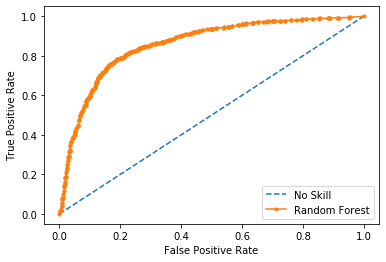

Eficiencia 0.7913999999999999  Int_Eficiencia 0.0039038442591886363  Sensibilidad 0.7913504965823309  Int_Sensibilidad 0.009956103649064626  Precision 0.7914322543505635  Int_Precision 0.007029626340355215  F-Score 0.7913351178351068  Int_F-Score 0.0054726193155323274  Error_Prueba 0.20859999999999998  Int_Error 0.0039038442591886272  Tiempo ejecución 11.57492971420288


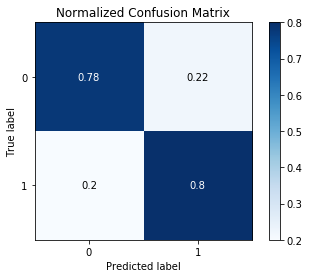

In [12]:
Acc, IntAcc, Sen, IntSen, Pre, IntPre, f, IntF, error, stdError, tiempo = model_RF(100, 5, impresion = True)
print('Eficiencia',Acc, ' Int_Eficiencia', IntAcc,' Sensibilidad', Sen, ' Int_Sensibilidad',IntSen,' Precision', Pre, ' Int_Precision',IntPre,' F-Score', f, ' Int_F-Score',IntF,' Error_Prueba', error,' Int_Error', stdError,' Tiempo ejecución', tiempo)

In [13]:
pd.options.mode.chained_assignment = None

randn = np.random.randn
df_types = pd.DataFrame({
    'Numero de arboles' : pd.Series([5,5,5,5,5,5,5,
                                     10,10,10,10,10,10,10,
                                     20,20,20,20,20,20,20,
                                     50,50,50,50,50,50,50,
                                     100,100,100,100,100,100,100]), 
    'Variables analizadas por nodo' : pd.Series([10,50,100,200,250,350,500,
                                                 10,50,100,200,250,350,500,
                                                 10,50,100,200,250,350,500,
                                                 10,50,100,200,250,350,500,
                                                 10,50,100,200,250,350,500])})
df_types["Eficiencia"] = ""
df_types["Int_Eficiencia"] = ""
df_types["Sensibilidad"] = ""
df_types["Int_Sensibilidad"] = ""
df_types["Precision"] = ""
df_types["Int_Precision"] = ""
df_types["F-Score"] = ""
df_types["Int_F-Score"] = ""
df_types["Error_Prueba"] = ""
df_types["Int_error"] = ""
df_types["Tiempo de ejecución"] = ""
df_types.set_index(['Numero de arboles','Variables analizadas por nodo'], inplace=True)

for n, k in df_types.index:
    Acc, IntAcc, Sen, IntSen, Pre, IntPre, f, IntF, error, stdError, tiempo = model_RF(n, k, impresion = False)
    df_types["Eficiencia"][n,k] = Acc
    df_types["Int_Eficiencia"][n,k] = IntAcc
    df_types["Sensibilidad"][n,k] = Sen
    df_types["Int_Sensibilidad"][n,k] = IntSen
    df_types["Precision"][n,k] = Pre
    df_types["Int_Precision"][n,k] = IntPre
    df_types["F-Score"][n,k] = f
    df_types["Int_F-Score"][n,k] = IntF
    df_types["Error_Prueba"][n,k] = error
    df_types["Int_error"][n,k] = stdError
    df_types["Tiempo de ejecución"][n,k] = tiempo

In [14]:
#df_types.sort_index(inplace=True)
qgrid_widget = qgrid.show_grid(df_types, show_toolbar=False)
qgrid_widget

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [15]:
qgrid_widget.get_changed_df()

Eficiencia  \
Numero de arboles Variables analizadas por nodo                       
5                 10                                         0.7597   
                  50                                         0.7592   
                  100                                        0.7502   
                  200                            0.7525000000000001   
                  250                            0.7567000000000002   
                  350                                        0.7603   
                  500                                        0.7492   
10                10                                         0.7786   
                  50                                         0.7653   
                  100                            0.7606999999999999   
                  200                            0.7585000000000001   
                  250                                        0.7601   
                  350                                        0.7598   
                  500                                        0.7616   
20                10                                         0.7888   
                  50                             0.7761999999999999   
                  100                                         0.779   
                  200                                        0.7723   
                  250                                        0.7719   
                  350                                        0.7642   
                  500                            0.7711999999999999   
50                10                                         0.7953   
                  50                                         0.7899   
                  100                                        0.7738   
                  200                            0.7755000000000001   
                  250                            0.7735000000000001   
                  350                                          0.77   
                  500                                        0.7705   
100               10                                          0.794   
                  50                             0.7797999999999999   
                  100                            0.7802000000000001   
                  200                            0.7807999999999999   
                  250                                        0.7744   
                  350                            0.7807000000000001   
                  500                            0.7635000000000001   

                                                        Int_Eficiencia  \
Numero de arboles Variables analizadas por nodo                          
5                 10                              0.007163099887618486   
                  50                              0.009461500938011905   
                  100                             0.006334035048845264   
                  200                             0.010439827584783205   
                  250                             0.010580642702596092   
                  350                             0.004926459174701433   
                  500                             0.005099019513592774   
10                10                              0.008440379138403698   
                  50                              0.006725325270944146   
                  100                            0.0035482389998419983   
                  200                             0.006081940479814009   
                  250                             0.008358827668997612   
                  350                             0.004643274706497583   
                  500                             0.002814249455894024   
20                10                              0.006968500556073745   
                  50                              0.009057593499379402   
                  100                              0.00510294032886924   
                  200  

# SVM

In [42]:
from sklearn.svm import SVC

In [43]:
def model_SVC(ker, C, gam, impresion = False):
    
    if gam == 0:
        gam = 'auto'

    svc = SVC(gamma=gam, C=float(C),  kernel=ker, decision_function_shape='ovo' , probability = True)

    tiempo_i = time.time()
    
    accuracy_list = np.zeros([4])
    accuracy_list_train = np.zeros([4])
    precision_list = np.zeros([4,2])
    recall_list = np.zeros([4,2])
    f_list = np.zeros([4,2]) 
    errores = np.zeros(4)
    list_acc_mean = []
    list_acc_train_mean = []
    list_acc_std = []
    list_acc_train_std = []
    list_percentage = [0.05,0.10,0.15,0.20,0.25,0.3]
    
    for i in list_percentage:
        for j in range(4):
            Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=i)
            scaler = MinMaxScaler()#Escala entre 0 y 1
            Xtrain = scaler.fit_transform(Xtrain)
            Xtest = scaler.transform(Xtest)

            svc.fit(Xtrain, Ytrain)
            pred = svc.predict(Xtest)
            pred_train = svc.predict(Xtrain)

            #code for calculating accuracy 
            _accuracy_ = accuracy_score(Ytest, pred, normalize=True)
            accuracy_list[j] = _accuracy_
            
            _accuracy_train_ = accuracy_score(Ytrain, pred_train, normalize=True)
            accuracy_list_train[j] = _accuracy_train_

            #code for calculating recall 
            _recalls_ = recall_score(Ytest, pred, average=None)
            recall_list[j] = _recalls_

            #code for calculating precision 
            _precisions_ = precision_score(Ytest, pred, average=None)
            precision_list[j] = _precisions_

            _f_score_ = f1_score(Ytest, pred, average=None)
            f_list[j] = _f_score_


            errores[j] = classification_error(pred, Ytest)
            print(i, j)
        
        list_acc_mean.append(np.mean(accuracy_list))
        list_acc_std.append(np.std(accuracy_list))
        list_acc_train_mean.append(np.mean(accuracy_list_train))
        list_acc_train_std.append(np.std(accuracy_list_train))
       
    
    if impresion == True:
        
        x = [10000-(i* 10000) for i in list_percentage]
        sneg = [m-s for m,s in zip(list_acc_mean,list_acc_std)]
        spos = [m+s for m,s in zip(list_acc_mean,list_acc_std)]
        
        sneg_train = [m-s for m,s in zip(list_acc_train_mean,list_acc_train_std)]
        spos_train = [m+s for m,s in zip(list_acc_train_mean,list_acc_train_std)]
        
        fig1, ax1 = plt.subplots()
        
        ax1.fill_between(x,sneg_train,spos_train,alpha=.4)
        ax1.plot(x, list_acc_train_mean, marker = 'v', label = "train")
        ax1.fill_between(x,sneg,spos,alpha=.4)
        ax1.plot(x, list_acc_mean, marker = 'p', label = "test")

        ax1.set_xlabel("Samples in train")
        ax1.set_ylabel("Accuracy")

        ax1.legend(loc="upper right", title="Learning curve", frameon=False)
        plt.show()
        
        #Curva ROC
        
        svc_probs = svc.predict_proba(Xtest)
        
        plot_roc(Xtest, Ytest, svc_probs, "SVM")
        skplt.metrics.plot_confusion_matrix(Ytest, pred, normalize=True)

    return str(np.mean(accuracy_list)), str(np.std(accuracy_list)), str(np.mean(recall_list)), str(np.std(recall_list)), str(np.mean(precision_list)), str(np.std(precision_list)), str(np.mean(f_list)), str(np.std(f_list)), str(np.mean(errores)), str(np.std(errores)), str(time.time()-tiempo_i)

0.05 0
0.05 1
0.05 2
0.05 3
0.1 0
0.1 1
0.1 2
0.1 3
0.15 0
0.15 1
0.15 2
0.15 3
0.2 0
0.2 1
0.2 2
0.2 3
0.25 0
0.25 1
0.25 2
0.25 3
0.3 0
0.3 1
0.3 2
0.3 3


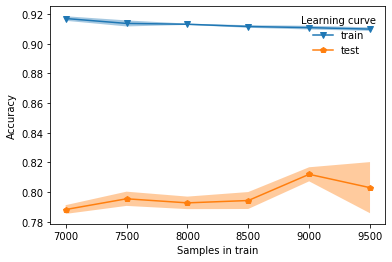

No Skill: ROC AUC=0.500
SVM ROC AUC=0.841


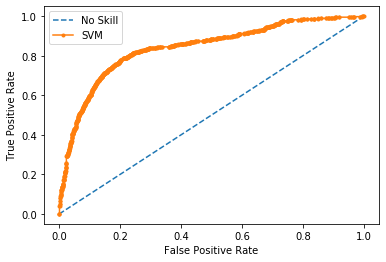

Eficiencia 0.7882500000000001  Int_Eficiencia 0.0029474565306379014  Sensibilidad 0.7888520202994267  Int_Sensibilidad 0.03362941944594068  Precision 0.7896482727378913  Int_Precision 0.02593468029255239  F-Score 0.7881455613291821  Int_F-Score 0.005589226690451573  Error_Prueba 0.21175  Int_Error 0.0029474565306379014  Tiempo ejecución 9488.403260469437


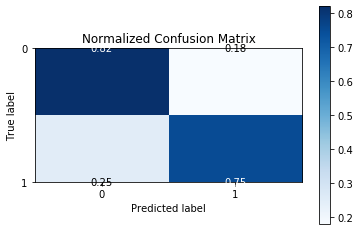

In [44]:
Acc, IntAcc, Sen, IntSen, Pre, IntPre, f, IntF, error, stdError, tiempo = model_SVC('rbf', 2, 1, impresion = True)
print('Eficiencia',Acc, ' Int_Eficiencia', IntAcc,' Sensibilidad', Sen, ' Int_Sensibilidad',IntSen,' Precision', Pre, ' Int_Precision',IntPre,' F-Score', f, ' Int_F-Score',IntF,' Error_Prueba', error,' Int_Error', stdError,' Tiempo ejecución', tiempo)

In [25]:
pd.options.mode.chained_assignment = None

randn = np.random.randn
df_types = pd.DataFrame({
    'Kernel' : pd.Series(['linear','linear','linear','rbf','rbf','rbf','rbf','rbf','rbf','rbf','rbf','rbf']),
    'C' : pd.Series([0.1,0.5,1, 0.1,0.1,0.1,0.5,0.5,0.5,1,1,1]),
    'gamma' : pd.Series([0,0,0, 0.1,0.5,1,0.1,0.5,1,0.1,0.5,1])})
df_types["Eficiencia"] = ""
df_types["Int_Eficiencia"] = ""
df_types["Sensibilidad"] = ""
df_types["Int_Sensibilidad"] = ""
df_types["Precision"] = ""
df_types["Int_Precision"] = ""
df_types["F-Score"] = ""
df_types["Int_F-Score"] = ""
df_types["Error_Prueba"] = ""
df_types["Int_error"] = ""
df_types["Tiempo de ejecución"] = ""
df_types.set_index(['Kernel','C','gamma'], inplace=True)

for n, k, o in df_types.index:
    Acc, IntAcc, Sen, IntSen, Pre, IntPre, f, IntF, error, stdError, tiempo = model_SVC(n, k, o, impresion = False)
    df_types["Eficiencia"][n,k,o] = Acc
    df_types["Int_Eficiencia"][n,k,o] = IntAcc
    df_types["Sensibilidad"][n,k,o] = Sen
    df_types["Int_Sensibilidad"][n,k,o] = IntSen
    df_types["Precision"][n,k,o] = Pre
    df_types["Int_Precision"][n,k,o] = IntPre
    df_types["F-Score"][n,k,o] = f
    df_types["Int_F-Score"][n,k,o] = IntF
    df_types["Error_Prueba"][n,k,o] = error
    df_types["Int_error"][n,k,o] = stdError
    df_types["Tiempo de ejecución"][n,k,o] = tiempo


#df_types.sort_index(inplace=True)
qgrid_widget = qgrid.show_grid(df_types, show_toolbar=False)

In [26]:
qgrid_widget.get_changed_df()

Eficiencia         Int_Eficiencia  \
Kernel C   gamma                                              
linear 0.1 0.0    0.7747999999999999   0.004955804677345552   
       0.5 0.0                0.7789   0.010704671877269319   
       1.0 0.0                0.7801  0.0068080834307461535   
rbf    0.1 0.1    0.7444999999999999   0.008344459239519392   
           0.5    0.7678999999999999   0.005631163290120439   
           1.0                0.7625  0.0031160872901765495   
       0.5 0.1                0.7787   0.006186275131288614   
           0.5    0.7918999999999999   0.002958039891549837   
           1.0                0.7858   0.008224354077980833   
       1.0 0.1                0.7872   0.005885575587824865   
           0.5                0.7875   0.005465345368775882   
           1.0                0.7933   0.004448595283907032   

                        Sensibilidad      Int_Sensibilidad  \
Kernel C   gamma                                             
linear 0.1 0.0    0.7751359976597543  0.023997089046480357   
       0.5 0.0    0.7790064333461693    0.0254862554007484   
       1.0 0.0    0.7800121522901072  0.032065814676345825   
rbf    0.1 0.1    0.7452507304382419   0.07116656289624222   
           0.5    0.7681113981294122   0.01415581182635652   
           1.0    0.7624795708795614  0.022536468681623914   
       0.5 0.1    0.7789436860381942  0.024917063460229774   
           0.5    0.7920004183108657   0.01830863700560201   
           1.0    0.7858399299635496  0.013155313383356508   
       1.0 0.1    0.7874211262676954   0.02228893614635278   
           0.5    0.7875611009290306  0.020939887152455764   
           1.0    0.7932530030434355  0.017596891367112136   

                           Precision         Int_Precision  \
Kernel C   gamma                                             
linear 0.1 0.0    0.7755000658013582   0.01887160199318247   
       0.5 0.0    0.7794759295749044  0.018796084977382336   
       1.0 0.0    0.7810917217119081  0.018903242435267982   
rbf    0.1 0.1    0.7498626881504818   0.03956955663930509   
           0.5     0.768095765346243   0.01452831930887497   
           1.0    0.7629765983210287  0.013017187531421004   
       0.5 0.1    0.7793484326547894   0.01912575659529477   
           0.5    0.7922735847319283  0.013394006406240489   
           1.0    0.7859182324286621  0.011267037629672216   
       1.0 0.1    0.7877427063416971  0.017179054544406193   
           0.5    0.7879804644874848  0.014286314334955884   
           1.0    0.7935281744151577  0.012482317193245107   

                             F-Score           Int_F-Score  \
Kernel C   gamma                                             
linear 0.1 0.0    0.7747660202642608  0.005642844969110446   
       0.5 0.0    0.7787669570899196  0.011941092247285998   
       1.0 0.0    0.7798091778653822  0.010683852884216161   
rbf    0.1 0.1     0.743421689579108  0.019626769727095334   
           0.5    0.7678832414572246  0.005955863403657401   
           1.0    0.7623437218739818  0.006790411643698109   
       0.5 0.1    0.7785981127585304  0.007926752512730744   
           0.5    0.7918402918282719  0.004665759109679375   
           1.0    0.7857783182572342  0.008501472255821266   
       1.0 0.1    0.7871350509875528  0.007023606325229401   
           0.5    0.7874248084921718  0.006736635923124592   
           1.0       0.7931568222692  0.006971221074770371   

                         Error_Prueba              Int_error  \
Kernel C   gamma                                               
linear 0.1 0.0                 0.2252  0.0049558046773455445   
       0.5 0.0    0.22109999999999996   0.010704671877269284   
       1.0 0.0                 0.2199   0.006808083430746133   
rbf    0.1 0.1                 0.2555   0.008344459239519349   
           0.5                 0.2321   0.005631163290120433   
           1.0                 0.2375  0.0031160872901765803   
       0.5 0.1          

# MLP

In [21]:
from sklearn.neural_network import MLPClassifier

In [39]:
def model_MLP(nCO, nPC, impresion = False, alpha=0.0001):
    
    if(nCO==1):
        mlp=MLPClassifier(activation='tanh',max_iter = 1000,hidden_layer_sizes=(nPC), alpha=alpha)
    else:
        layers = tuple((nPC for i in range(nCO)))
        mlp=MLPClassifier(activation='tanh',max_iter = 1000,hidden_layer_sizes=layers, alpha=alpha)
        
    tiempo_i = time.time()
    
    accuracy_list = np.zeros([4])
    accuracy_list_train = np.zeros([4])
    precision_list = np.zeros([4,2])
    recall_list = np.zeros([4,2])
    f_list = np.zeros([4,2]) 
    errores = np.zeros(4)
    list_acc_mean = []
    list_acc_train_mean = []
    list_acc_std = []
    list_acc_train_std = []
    list_percentage = [0.05,0.10,0.15,0.20,0.25,0.3]
    
    for i in list_percentage:
        for j in range(4):
            Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=i)
            scaler = MinMaxScaler()#Escala entre 0 y 1
            Xtrain = scaler.fit_transform(Xtrain)
            Xtest = scaler.transform(Xtest)

            mlp.fit(Xtrain, Ytrain)
            pred = mlp.predict(Xtest)
            pred_train = mlp.predict(Xtrain)

            #code for calculating accuracy 
            _accuracy_ = accuracy_score(Ytest, pred, normalize=True)
            accuracy_list[j] = _accuracy_
            
            _accuracy_train_ = accuracy_score(Ytrain, pred_train, normalize=True)
            accuracy_list_train[j] = _accuracy_train_

            #code for calculating recall 
            _recalls_ = recall_score(Ytest, pred, average=None)
            recall_list[j] = _recalls_

            #code for calculating precision 
            _precisions_ = precision_score(Ytest, pred, average=None)
            precision_list[j] = _precisions_

            _f_score_ = f1_score(Ytest, pred, average=None)
            f_list[j] = _f_score_


            errores[j] = classification_error(pred, Ytest)
            print(i, j)
        
        list_acc_mean.append(np.mean(accuracy_list))
        list_acc_std.append(np.std(accuracy_list))
        list_acc_train_mean.append(np.mean(accuracy_list_train))
        list_acc_train_std.append(np.std(accuracy_list_train))
       
    
    if impresion == True:
        
        x = [10000-(i* 10000) for i in list_percentage]
        sneg = [m-s for m,s in zip(list_acc_mean,list_acc_std)]
        spos = [m+s for m,s in zip(list_acc_mean,list_acc_std)]
        
        sneg_train = [m-s for m,s in zip(list_acc_train_mean,list_acc_train_std)]
        spos_train = [m+s for m,s in zip(list_acc_train_mean,list_acc_train_std)]
        
        fig1, ax1 = plt.subplots()
        
        ax1.fill_between(x,sneg_train,spos_train,alpha=.4)
        ax1.plot(x, list_acc_train_mean, marker = 'v', label = "train")
        ax1.fill_between(x,sneg,spos,alpha=.4)
        ax1.plot(x, list_acc_mean, marker = 'p', label = "test")

        ax1.set_xlabel("Número de muestras para train")
        ax1.set_ylabel("Accuracy")

        ax1.legend(loc="upper right", title="Curva de aprendizaje", frameon=False)
        plt.show()
        
        #Curva ROC
        
        mlp_probs = mlp.predict_proba(Xtest)
        
        plot_roc(Xtest, Ytest, mlp_probs, "MLP")
        skplt.metrics.plot_confusion_matrix(Ytest, pred, normalize=True)

    return str(np.mean(accuracy_list)), str(np.std(accuracy_list)), str(np.mean(recall_list)), str(np.std(recall_list)), str(np.mean(precision_list)), str(np.std(precision_list)),  str(np.mean(f_list)), str(np.std(f_list)), str(np.mean(errores)), str(np.std(errores)), str(time.time()-tiempo_i)

0.05 0
0.05 1
0.05 2
0.05 3
0.1 0
0.1 1
0.1 2
0.1 3
0.15 0
0.15 1
0.15 2
0.15 3
0.2 0
0.2 1
0.2 2
0.2 3
0.25 0
0.25 1
0.25 2
0.25 3
0.3 0
0.3 1
0.3 2
0.3 3


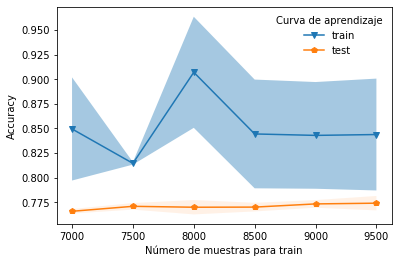

No Skill: ROC AUC=0.500
MLP ROC AUC=0.847


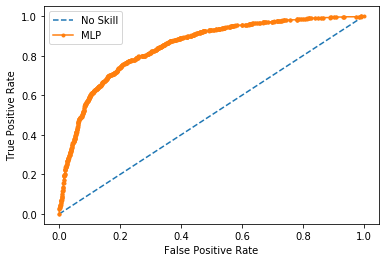

Eficiencia 0.76575  Int_Eficiencia 0.002277608394786084  Sensibilidad 0.7659747101910501  Int_Sensibilidad 0.03266879085727927  Precision 0.7668974089101989  Int_Precision 0.021338258974303675  F-Score 0.7655184207926649  Int_F-Score 0.007687681648290288  Error_Prueba 0.23425  Int_Error 0.002277608394786073  Tiempo ejecución 905.784099817276


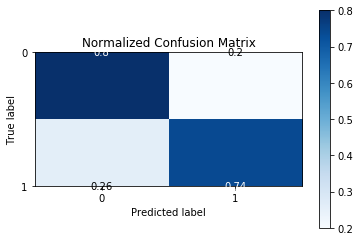

In [41]:
Acc, IntAcc, Sen, IntSen, Pre, IntPre, f, IntF, error, stdError, tiempo = model_MLP(1, 30, impresion = True, alpha=0.00001)
print('Eficiencia',Acc, ' Int_Eficiencia', IntAcc,' Sensibilidad', Sen, ' Int_Sensibilidad',IntSen,' Precision', Pre, ' Int_Precision',IntPre,' F-Score', f, ' Int_F-Score',IntF,' Error_Prueba', error,' Int_Error', stdError,' Tiempo ejecución', tiempo)

In [19]:
pd.options.mode.chained_assignment = None

randn = np.random.randn
df_types = pd.DataFrame({
    'N. de capas ocultas' : pd.Series([1,1,1,1,1,2,2,2,2,2,3,3,3,3,3,4,4,4,4,4,5,5,5,5,5]),
    'Neuronas por capa' : pd.Series([20,30,40,50,75,20,30,40,50,75,20,30,40,50,75,20,30,40,50,75,20,30,40,50,75])})
df_types["Eficiencia"] = ""
df_types["Int_Eficiencia"] = ""
df_types["Sensibilidad"] = ""
df_types["Int_Sensibilidad"] = ""
df_types["Precision"] = ""
df_types["Int_Precision"] = ""
df_types["F-Score"] = ""
df_types["Int_F-Score"] = ""
df_types["Error_Prueba"] = ""
df_types["Int_error"] = ""
df_types["Tiempo de ejecución"] = ""
df_types.set_index(['N. de capas ocultas','Neuronas por capa'], inplace=True)
    
for n, k in df_types.index:
    Acc, IntAcc, Sen, IntSen, Pre, IntPre, f, IntF, error, stdError, tiempo = model_MLP(n, k, impresion = False)
    df_types["Eficiencia"][n,k] = Acc
    df_types["Int_Eficiencia"][n,k] = IntAcc
    df_types["Sensibilidad"][n,k] = Sen
    df_types["Int_Sensibilidad"][n,k] = IntSen
    df_types["Precision"][n,k] = Pre
    df_types["Int_Precision"][n,k] = IntPre
    df_types["F-Score"][n,k] = f
    df_types["Int_F-Score"][n,k] = IntF
    df_types["Error_Prueba"][n,k] = error
    df_types["Int_error"][n,k] = stdError
    df_types["Tiempo de ejecución"][n,k] = tiempo
    
qgrid_widget = qgrid.show_grid(df_types, show_toolbar=False)

In [20]:
qgrid_widget.get_changed_df()

Eficiencia  \
N. de capas ocultas Neuronas por capa                       
1                   20                 0.7630000000000001   
                    30                             0.7697   
                    40                             0.7697   
                    50                             0.7662   
                    75                             0.7686   
2                   20                 0.7494000000000001   
                    30                             0.7499   
                    40                 0.7424000000000002   
                    50                             0.7469   
                    75                             0.7432   
3                   20                             0.7448   
                    30                             0.7418   
                    40                             0.7403   
                    50                             0.7344   
                    75                             0.7468   
4                   20                 0.7444999999999999   
                    30                             0.7463   
                    40                              0.741   
                    50                             0.7457   
                    75                             0.7437   
5                   20                             0.7418   
                    30                             0.7456   
                    40                 0.7439999999999999   
                    50                             0.7418   
                    75                              0.742   

                                              Int_Eficiencia  \
N. de capas ocultas Neuronas por capa                          
1                   20                  0.002126029162546931   
                    30                  0.006009159675029433   
                    40                  0.007814729681825217   
                    50                  0.002807133769523663   
                    75                  0.004440720662234906   
2                   20                  0.011122949249187464   
                    30                  0.005465345368775881   
                    40                 0.0032741411087489824   
                    50                  0.003374907406137261   
                    75                  0.006311893535223773   
3                   20                 0.0029529646120466974   
                    30                  0.009734474818910354   
                    40                  0.012339773093537832   
                    50                 0.0012328828005938217   
                    75                  0.005403702434442517   
4                   20                 0.0035142566781610996   
                    30                  0.010977704678119177   
                    40                  0.009141115905621135   
                    50                    0.0133727334528136   
                    75                 0.0014525839046333974   
5                   20                  0.007158212067269309   
                    30                  0.004409081537009733   
                    40                 0.0048166378315169355   
                    50                  0.010615083607772463   
                    75                  0.013690872872099847   

                                             Sensibilidad  \
N. de capas ocultas Neuronas por capa                       
1                   20                  0.762923765456054   
                    30                 0.7702273254923178   
                    40                 0.7701557418630455   
                    50                 0.7662309948777006   
                    75                   0.76856604842056   
2                   20                 0.7491990510994574   
                    30                 0.7497926568566275   
                    40                 0.7424495268903197   
                    50                  0.746876520733465   